In [1]:
%matplotlib inline

In [2]:
# 単変量LSTMでsin波予測 (チュートリアルとして規則性のあるデータを予測)

In [3]:
# データ

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# sin波生成
def sin(length=100, curve=4):
    x = np.arange(0, length)
    return np.sin((curve * np.pi) * x / length)

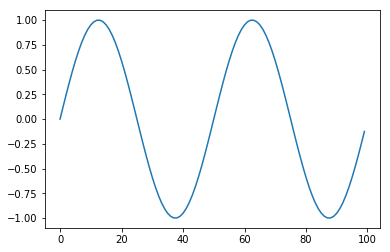

In [6]:
plt.plot(sin())
plt.show()

In [7]:
# ノイズ付きsin波
def noised_sin(length=100, curve=4, noise_rate=0.1, low=-1.0, high=1.0):
    x = sin(length=length, curve=curve)
    noise = noise_rate * np.random.uniform(low=low, high=high, size=len(x))
    return x + noise

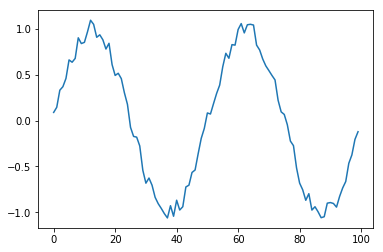

In [8]:
plt.plot(noised_sin())
plt.show()

In [9]:
# 学習用時系列データとして整形
def create_reccurent_dataset(vector_data, step=25):
    data, target = [], []
    for i in range(len(vector_data) - step):
        data.append(vector_data[i:(i + step)])
        target.append(vector_data[i + step])
    reshape_data = np.array(data).reshape(len(data), step, 1)
    reshape_label = np.array(target).reshape(len(data), 1)
    return reshape_data, reshape_label

In [10]:
# 形状と内容の確認
train_data, train_label = create_reccurent_dataset([1,2,3,4,5,6,7,8,9], 3)

In [11]:
# 学習データ、stepで区切った時系列データ、3次元配列
# なぜ3次元なのか = 他にも気温、湿度、曜日など予測に役立ちそうなデータを入れられる。
# 今回は1個のデータのみ
# (学習データ総数, 1学習の時系列数(ステップ数), 特徴量)
print(train_data.shape)
print(train_data)

(6, 3, 1)
[[[1]
  [2]
  [3]]

 [[2]
  [3]
  [4]]

 [[3]
  [4]
  [5]]

 [[4]
  [5]
  [6]]

 [[5]
  [6]
  [7]]

 [[6]
  [7]
  [8]]]


In [12]:
# 答えラベル、次に来るべき値、2次元配列
print(train_label.shape)
print(train_label)

(6, 1)
[[4]
 [5]
 [6]
 [7]
 [8]
 [9]]


In [13]:
# ノイズ付きsin波予測
data = noised_sin(length=100, curve=4, noise_rate=0.1)
train_data, train_label = create_reccurent_dataset(data, step=25)

In [14]:
train_data.shape

(75, 25, 1)

In [15]:
train_label.shape

(75, 1)

In [16]:
# モデル構築

In [17]:
# 時系列(長短期記憶)学習モデルの種類
# RNN, LSTM, [QRNN](https://qiita.com/icoxfog417/items/d77912e10a7c60ae680e)...他
# LSTM
#   LSTM(1D) 例: 1次元の時系列データを入力として利用する
#   ConvLSTM2D 例: 動画を時系列データを入力として利用する
#   ConvLSTM3D 例: 空間の変化を時系列データを入力として利用する

In [18]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation, LSTM
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping

In [19]:
step_count = 25 # 1つの学習データのStep数(今回は25)
feature_count = 1 # 特徴量 今回の学習するデータは1個のみ
hidden_unit_count = 300 # 中間層の数だと思う (公式は:出力の次元数?) https://keras.io/ja/layers/recurrent/#lstm

In [20]:
model = Sequential()
model.add(LSTM(hidden_unit_count, batch_input_shape=(None, step_count, feature_count), return_sequences=False))
model.add(Dense(1))
model.add(Activation('linear'))
optimizer = Adam(lr=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer)

In [21]:
model.output_shape

(None, 1)

In [22]:
# 早期終了 過学習抑制、打ち切る手法 過学習(Over fitting)に陥ることを避けつつ、簡単にエポック数を考える手間を減らすことができる
# 30~50epochsくらいで十分学習できたと判断して終了するはず
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)

In [ ]:
# トレーニング
model.fit(
    train_data, train_label,
    batch_size=300,
    epochs=100,
    validation_split=0.1,
    callbacks=[early_stopping]
)

In [24]:
# 推論、検証
predictions = model.predict(train_data)

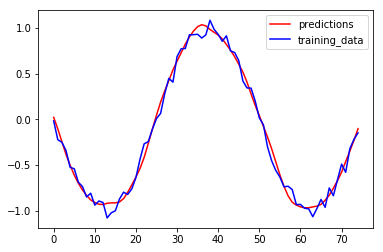

In [25]:
plt.figure()
plt.plot(range(0, len(predictions)), predictions, color='r', label='predictions')
plt.plot(range(0, len(train_label)), train_label, color='b', label='training_data')
plt.legend()
plt.show()

In [26]:
# 未来予測
latest_data = train_data[len(train_data)-1]
results = np.empty((0, 0))
for _ in range(50):
    # 推論
    test_data = np.reshape(latest_data, (1, 25, 1))
    batch_predict = model.predict(test_data)

    # 結果蓄積
    results = np.append(results, batch_predict)

    # 次のデータをセット
    latest_data = np.delete(latest_data, 0)
    latest_data = np.append(latest_data, batch_predict)

# (50)から(50,1)に形状を変える
results = np.reshape(results, (results.shape[0], 1))

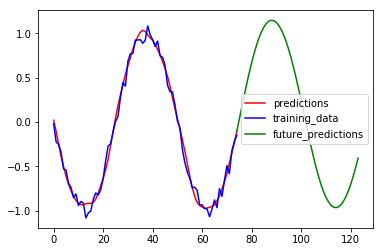

In [27]:
plt.figure()
plt.plot(range(0, len(predictions)), predictions, color='r', label='predictions')
plt.plot(range(0, len(train_label)), train_label, color='b', label='training_data')
plt.plot(range(len(train_label)-1, len(train_label)-1+len(results)), results, color='g', label='future_predictions')
plt.legend()
plt.show()

In [28]:
# 多変量LSTMでアイスクリームの売り上げ予測 (ある程度規則性のあるデータで、売上だけではなく気温なども考慮した予測)
# 参考データ(使いやすいように加工してます): https://oku.edu.mie-u.ac.jp/~okumura/stat/160118.html

import pandas

In [29]:
data = pandas.read_csv('volume/datasets/tokyo-weather-and-ice-sales.csv')
data

,year,month,avg_max_temperature,sum_precipitation_mm,avg_humidity_per,25c_days,ice_sale
0,2003,1,9.3,101.0,46,0,331
1,2003,2,9.9,53.5,52,0,268
2,2003,3,12.7,159.5,49,0,365
3,2003,4,19.2,121.0,61,3,492
4,2003,5,22.4,172.5,65,7,632
5,2003,6,26.6,85.0,69,21,730
6,2003,7,26.0,187.5,75,21,821
7,2003,8,29.5,370.0,73,26,1057
8,2003,9,28.1,150.0,66,23,724
9,2003,10,21.4,171.5,59,3,430


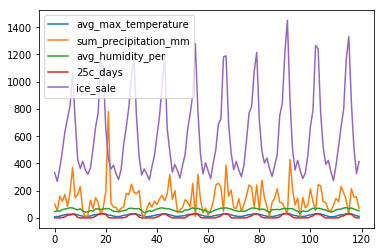

In [30]:
# year, month, avg_max_temperature, sum_precipitation_mm, avg_humidity_per, 25c_days, ice_sale
plt.plot(data['avg_max_temperature'], label='avg_max_temperature') # 最大気温平均
plt.plot(data['sum_precipitation_mm'], label='sum_precipitation_mm') # 合計降水量
plt.plot(data['avg_humidity_per'], label='avg_humidity_per') # 平均湿度
plt.plot(data['25c_days'], label='25c_days') # 25度以上の日数
plt.plot(data['ice_sale'], label='ice_sale') # アイスの売り上げ(円)
plt.legend()
plt.show()

In [31]:
# 最大気温平均, 合計降水量, 平均湿度, 25度以上の日数をもとに`アイスの売り上げ(円)`を予測します

temps = data['avg_max_temperature'].values.tolist() # 配列化
temps = np.array(temps).reshape((len(temps), 1)) # 形状変更 (120, 1)
print(temps.shape)

precs = data['sum_precipitation_mm'].values.tolist() # 配列化
precs = np.array(precs).reshape((len(precs), 1)) # 形状変更 (120, 1)
print(precs.shape)

humidities = data['avg_humidity_per'].values.tolist() # 配列化
humidities = np.array(humidities).reshape((len(humidities), 1)) # 形状変更 (120, 1)
print(humidities.shape)

up25days = data['25c_days'].values.tolist() # 配列化
up25days = np.array(up25days).reshape((len(up25days), 1)) # 形状変更 (120, 1)
print(up25days.shape)

icesales = data['ice_sale'].values.tolist() # 配列化
icesales = np.array(icesales).reshape((len(icesales), 1)) # 形状変更 (120, 1)
print(icesales.shape)

(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)


In [32]:
# 標準化
# すべての値を0~1の範囲に納める
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

normalized_temps = scaler.fit_transform(temps)
normalized_precs = scaler.fit_transform(precs)
normalized_humidities = scaler.fit_transform(humidities)
normalized_up25days = scaler.fit_transform(up25days)
normalized_icesales = scaler.fit_transform(icesales)

/Users/t01530/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [33]:
normalized_icesales[0:10]

array([[ 0.05325444],
       [ 0.        ],
       [ 0.08199493],
       [ 0.18934911],
       [ 0.30769231],
       [ 0.39053254],
       [ 0.46745562],
       [ 0.66694844],
       [ 0.38546069],
       [ 0.13693998]])

In [34]:
# 一年周期で変動する月のデータなので12step
# 余談、ちょくちょくデータ内容確認した方がいい。normalized_icesalesをicesalesとtypoしてicesalesだけ300倍率くらいのデータになって学習時にハマる。。
temps_train_data, temps_train_label = create_reccurent_dataset(normalized_temps, step=12)
precs_train_data, precs_train_label = create_reccurent_dataset(normalized_precs, step=12)
up25days_train_data, up25days_train_label = create_reccurent_dataset(normalized_up25days, step=12)
humidities_train_data, humidities_train_label = create_reccurent_dataset(normalized_humidities, step=12)
icesales_train_data, icesales_train_label = create_reccurent_dataset(normalized_icesales, step=12)
print(temps_train_data.shape)
print(temps_train_label.shape)
print(precs_train_data.shape)
print(precs_train_label.shape)
print(up25days_train_data.shape)
print(up25days_train_label.shape)
print(humidities_train_data.shape)
print(humidities_train_label.shape)
print(icesales_train_data.shape)
print(icesales_train_label.shape)

(108, 12, 1)
(108, 1)
(108, 12, 1)
(108, 1)
(108, 12, 1)
(108, 1)
(108, 12, 1)
(108, 1)
(108, 12, 1)
(108, 1)


In [35]:
# 推論する際の形状 = (個数, ステップ数, 特徴量(最大気温平均, 合計降水量, 平均湿度, 25度以上の日数))
# 今回の推論時の形状 = (個数, 12, 5)
# 入力も出力も最大気温平均, 合計降水量, 平均湿度, 25度以上の日数, アイスの売り上げ(円)の5つ
train_data = np.c_[temps_train_data, precs_train_data, up25days_train_data, humidities_train_data, icesales_train_data]
train_label = np.c_[temps_train_label, precs_train_label, up25days_train_label, humidities_train_label, icesales_train_label]
print(train_data.shape)
print(train_label.shape)

# train_data[0:5]
# train_label[0:5]

(108, 12, 5)
(108, 5)


In [36]:
# モデル構築
step_count = 12
feature_count = 5
hidden_unit_count = 120

model = Sequential()
model.add(LSTM(hidden_unit_count, batch_input_shape=(None, step_count, feature_count)))
model.add(Dense(feature_count))
model.add(Activation('linear'))
optimizer = Adam(lr=0.003)
model.compile(loss='mean_squared_error', optimizer=optimizer)
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)

In [ ]:
# トレーニング
model.fit(
    train_data, train_label,
    batch_size=2000,
    epochs=200,
    validation_split=0.1,
    callbacks=[early_stopping]
)

In [38]:
# 推論、検証
predictions = model.predict(train_data)
predictions[0:5]

array([[ 0.13300116,  0.06377129,  0.03130407,  0.27280456,  0.10059522],
       [ 0.16203393,  0.08255602,  0.02350706,  0.280294  ,  0.09242289],
       [ 0.27343231,  0.13102677,  0.05511301,  0.38830504,  0.12367076],
       [ 0.42507336,  0.16793308,  0.14566593,  0.54688025,  0.19874515],
       [ 0.58188057,  0.19439954,  0.34718585,  0.69230473,  0.34454843]], dtype=float32)

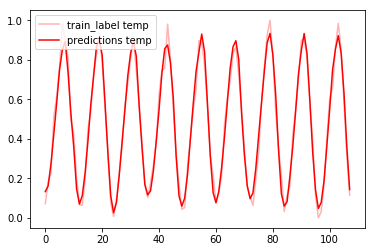

In [39]:
# 最大気温平均
plt.figure()
plt.plot(range(0, len(train_label)), train_label[:,0], color=(1.0, 0.7, 0.7), label='train_label temp')
plt.plot(range(0, len(predictions)), predictions[:,0], color=(1.0, 0.0, 0.0), label='predictions temp')
plt.legend()
plt.show()

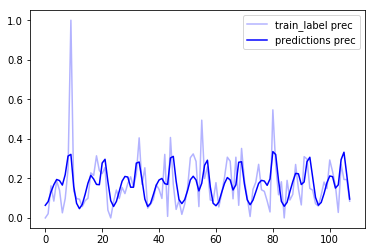

In [40]:
# 合計降水量
plt.figure()
plt.plot(range(0, len(train_label)), train_label[:,1], color=(0.7, 0.7, 1.0), label='train_label prec')
plt.plot(range(0, len(predictions)), predictions[:,1], color=(0.0, 0.0, 1.0), label='predictions prec')
plt.legend()
plt.show()

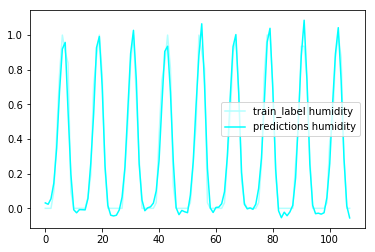

In [41]:
# 平均湿度
plt.figure()
plt.plot(range(0, len(train_label)), train_label[:,2], color=(0.7, 1.0, 1.0), label='train_label humidity')
plt.plot(range(0, len(predictions)), predictions[:,2], color=(0.0, 1.0, 1.0), label='predictions humidity')
plt.legend()
plt.show()

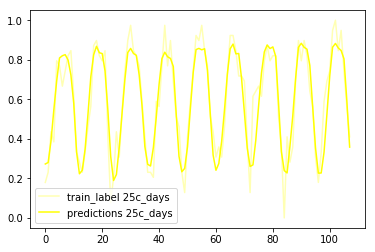

In [42]:
# 25度以上の日数
plt.figure()
plt.plot(range(0, len(train_label)), train_label[:,3], color=(1.0, 1.0, 0.7), label='train_label 25c_days')
plt.plot(range(0, len(predictions)), predictions[:,3], color=(1.0, 1.0, 0.0), label='predictions 25c_days')
plt.legend()
plt.show()

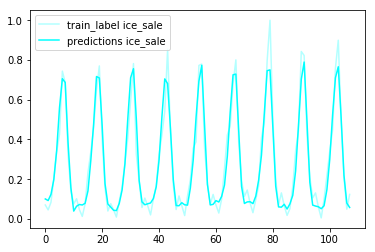

In [43]:
# アイスの売り上げ
plt.figure()
plt.plot(range(0, len(train_label)), train_label[:,4], color=(0.7, 1.0, 1.0), label='train_label ice_sale')
plt.plot(range(0, len(predictions)), predictions[:,4], color=(0.0, 1.0, 1.0), label='predictions ice_sale')
plt.legend()
plt.show()

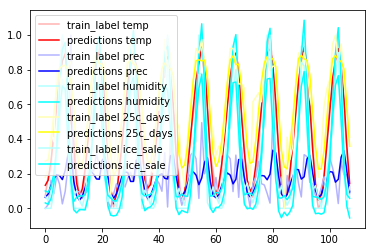

In [44]:
# すべて
plt.figure()
plt.plot(range(0, len(train_label)), train_label[:,0], color=(1.0, 0.7, 0.7), label='train_label temp')
plt.plot(range(0, len(predictions)), predictions[:,0], color=(1.0, 0.0, 0.0), label='predictions temp')
plt.plot(range(0, len(train_label)), train_label[:,1], color=(0.7, 0.7, 1.0), label='train_label prec')
plt.plot(range(0, len(predictions)), predictions[:,1], color=(0.0, 0.0, 1.0), label='predictions prec')
plt.plot(range(0, len(train_label)), train_label[:,2], color=(0.7, 1.0, 1.0), label='train_label humidity')
plt.plot(range(0, len(predictions)), predictions[:,2], color=(0.0, 1.0, 1.0), label='predictions humidity')
plt.plot(range(0, len(train_label)), train_label[:,3], color=(1.0, 1.0, 0.7), label='train_label 25c_days')
plt.plot(range(0, len(predictions)), predictions[:,3], color=(1.0, 1.0, 0.0), label='predictions 25c_days')
plt.plot(range(0, len(train_label)), train_label[:,4], color=(0.7, 1.0, 1.0), label='train_label ice_sale')
plt.plot(range(0, len(predictions)), predictions[:,4], color=(0.0, 1.0, 1.0), label='predictions ice_sale')
plt.legend()
plt.show()

In [45]:
# 未来予測 5ヶ月後
latest_data = np.array([train_data[len(train_data)-1]])
results = []
for _ in range(5):
    # 推論
    print(latest_data.shape)
    batch_predict = model.predict(latest_data)
    # 結果蓄積
    results.append([batch_predict[0][0], batch_predict[0][1], batch_predict[0][2], batch_predict[0][3], batch_predict[0][4]])
    # 次のデータをセット
    latest_data = np.delete(latest_data, np.array([batch_predict]), axis=1)
    latest_data = np.append(latest_data, np.array([batch_predict]), axis=1)
results = np.array(results)
results.shape

(1, 12, 5)
(1, 12, 5)
(1, 12, 5)
(1, 12, 5)
(1, 12, 5)


/Users/t01530/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


(5, 5)

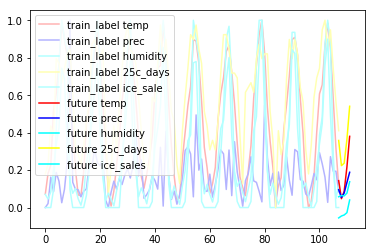

In [46]:
plt.figure()

plt.plot(range(0, len(train_label)), train_label[:,0], color=(1.0, 0.7, 0.7), label='train_label temp')
plt.plot(range(0, len(train_label)), train_label[:,1], color=(0.7, 0.7, 1.0), label='train_label prec')
plt.plot(range(0, len(train_label)), train_label[:,2], color=(0.7, 1.0, 1.0), label='train_label humidity ')
plt.plot(range(0, len(train_label)), train_label[:,3], color=(1.0, 1.0, 0.7), label='train_label 25c_days')
plt.plot(range(0, len(train_label)), train_label[:,4], color=(0.7, 1.0, 1.0), label='train_label ice_sale')

plt.plot(range(len(train_label)-1, len(train_label)-1+len(results)), results[:,0], color=(1.0, 0.0, 0.0), label='future temp')
plt.plot(range(len(train_label)-1, len(train_label)-1+len(results)), results[:,1], color=(0.0, 0.0, 1.0), label='future prec')
plt.plot(range(len(train_label)-1, len(train_label)-1+len(results)), results[:,2], color=(0.0, 1.0, 1.0), label='future humidity')
plt.plot(range(len(train_label)-1, len(train_label)-1+len(results)), results[:,3], color=(1.0, 1.0, 0.0), label='future 25c_days')
plt.plot(range(len(train_label)-1, len(train_label)-1+len(results)), results[:,4], color=(0.0, 1.0, 1.0), label='future ice_sales')

plt.legend()
plt.show()

In [47]:
# pybitflyer データ取得

In [48]:
import pybitflyer

In [49]:
api = pybitflyer.API()
data = api.ticker(product_code='BTC_JPY')

In [50]:
data

{'best_ask': 731099.0,
 'best_ask_size': 0.0346,
 'best_bid': 731002.0,
 'best_bid_size': 0.01,
 'ltp': 731000.0,
 'product_code': 'BTC_JPY',
 'tick_id': 5034910,
 'timestamp': '2018-04-07T13:57:14.457',
 'total_ask_depth': 3594.1090492,
 'total_bid_depth': 3647.81480263,
 'volume': 182302.14696931,
 'volume_by_product': 12484.83517511}

In [51]:
print(data['ltp']) # 最終取引価格
print(data['best_ask']) # 最高買い価格
print(data['best_bid']) # 最小売り価格

731000.0
731099.0
731002.0


In [52]:
# 単変量のLSTM
# まずは最終取引価格だけで最終取引価格を予測

In [53]:
import time
from datetime import datetime

In [54]:
btc_jpy_data = []
count = 5
api = pybitflyer.API()
while True:
    tick = api.ticker(product_code='BTC_JPY')
    print('tick={} ltp={}'.format(len(btc_jpy_data), tick['ltp']))
    btc_jpy_data.append(tick)
    time.sleep(1)
    if count <= len(btc_jpy_data):
        break

tick=0 ltp=731050.0
tick=1 ltp=731050.0
tick=2 ltp=731050.0
tick=3 ltp=731050.0
tick=4 ltp=731050.0


In [55]:
btc_jpy_data

[{'best_ask': 731330.0,
  'best_ask_size': 0.4994,
  'best_bid': 731063.0,
  'best_bid_size': 0.01044359,
  'ltp': 731050.0,
  'product_code': 'BTC_JPY',
  'tick_id': 5035154,
  'timestamp': '2018-04-07T13:57:25.18',
  'total_ask_depth': 3594.46944933,
  'total_bid_depth': 3647.65878779,
  'volume': 182345.21995451,
  'volume_by_product': 12477.62096551},
 {'best_ask': 731329.0,
  'best_ask_size': 0.0299,
  'best_bid': 731063.0,
  'best_bid_size': 0.01044359,
  'ltp': 731050.0,
  'product_code': 'BTC_JPY',
  'tick_id': 5035174,
  'timestamp': '2018-04-07T13:57:25.93',
  'total_ask_depth': 3593.6883492,
  'total_bid_depth': 3646.19878753,
  'volume': 182327.66140275,
  'volume_by_product': 12477.52096551},
 {'best_ask': 731329.0,
  'best_ask_size': 0.0299,
  'best_bid': 731063.0,
  'best_bid_size': 0.01044359,
  'ltp': 731050.0,
  'product_code': 'BTC_JPY',
  'tick_id': 5035204,
  'timestamp': '2018-04-07T13:57:27.15',
  'total_ask_depth': 3593.00634907,
  'total_bid_depth': 3644.450980

In [56]:
# ファイルから
import json
with open('volume/datasets/BTC_JPY.json', 'r') as f:
    btc_jpy_data = json.load(f)

In [ ]:
btc_jpy_data

In [57]:
# ltpだけ利用
data = [[d['ltp']] for d in btc_jpy_data]

In [ ]:
data

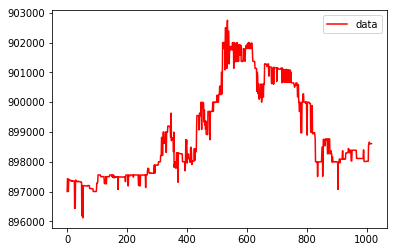

In [59]:
plt.figure()
plt.plot(range(0, len(data)), data, color='r', label='data')
plt.legend()
plt.show()

In [60]:
# 標準化
# すべての値を0~1の範囲に納める
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = scaler.fit_transform(data)
print(normalized_data)

[[ 0.13355442]
 [ 0.19882424]
 [ 0.19882424]
 ..., 
 [ 0.37564064]
 [ 0.37564064]
 [ 0.37564064]]


In [61]:
train_data, train_label = create_reccurent_dataset(normalized_data, step=5)
print(train_data.shape)
print(train_label.shape)

(1012, 5, 1)
(1012, 1)


In [62]:
# モデル構築
# 学習率の調整がキモ?? 0.00001だと200stepでも不安定、0.0001なら50step程度でEarlyStoppingする
step_count = 5
feature_count = 1
hidden_unit_count = 300
model = Sequential()
model.add(LSTM(hidden_unit_count, batch_input_shape=(None, step_count, feature_count), return_sequences=False))
model.add(Dense(feature_count))
model.add(Activation('linear'))
optimizer = Adam(lr=0.0001) # 学習率 0.001 -> 0.003 -> 0.03 -> 0.01
model.compile(loss='mean_squared_error', optimizer=optimizer)
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=0)

In [ ]:
# トレーニング
model.fit(
    train_data, train_label,
    batch_size=2000,
    epochs=200,
    validation_split=0.1,
    callbacks=[early_stopping]
)

In [64]:
model.predict(np.array([[[1.0],[0.8],[0.6],[0.4],[0.2]]]))[0][0]

0.58764488

In [65]:
model.predict(np.array([[[0.0],[0.0],[0.0],[0.0],[0.0]]]))[0][0]

0.11019745

In [66]:
model.predict(np.array([[[1.0],[1.0],[1.0],[1.0],[1.0]]]))[0][0]

0.82122368

In [67]:
model.predict(np.array([[[0.2],[0.4],[0.6],[0.8],[1.0]]]))[0][0]

0.46118355

In [68]:
# 推論、検証
predictions = model.predict(train_data)

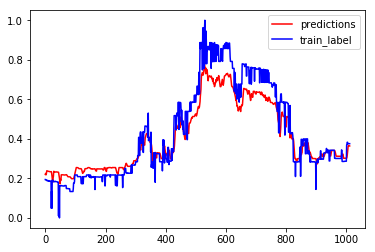

In [69]:
plt.figure()
plt.plot(range(0, len(predictions)), predictions, color='r', label='predictions')
plt.plot(range(0, len(train_label)), train_label, color='b', label='train_label')
plt.legend()
plt.show()

In [70]:
# 未来予測
latest_data = train_data[len(train_data)-1]
results = np.empty((0, 0))
for _ in range(50):
    # 推論
    test_data = np.reshape(latest_data, (1, 5, 1))
    batch_predict = model.predict(test_data)
    # 結果蓄積
    results = np.append(results, batch_predict)
    # 次のデータをセット
    latest_data = np.delete(latest_data, 0)
    latest_data = np.append(latest_data, batch_predict)

# (個数)から(個数,1)に形状を変える
results = np.reshape(results, (results.shape[0], 1))

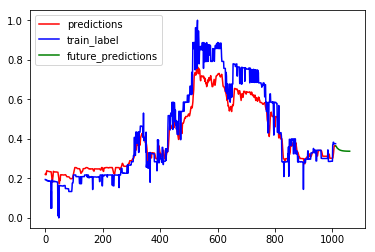

In [71]:
plt.figure()
plt.plot(range(0, len(predictions)), predictions, color='r', label='predictions')
plt.plot(range(0, len(train_label)), train_label, color='b', label='train_label')
plt.plot(range(len(train_label)-1, len(train_label)-1+len(results)), results, color='g', label='future_predictions')
plt.legend()
plt.show()

In [72]:
# 多変量のLSTM
# 利用する特徴 ltp, best_ask, best_bid

In [73]:
ltp_data = np.array([[d['ltp']] for d in btc_jpy_data])
best_ask_data = np.array([[d['best_ask']] for d in btc_jpy_data])
best_bid_data = np.array([[d['best_bid']] for d in btc_jpy_data])

In [74]:
# 標準化
scaler = MinMaxScaler(feature_range=(0, 1))
ltp_data = scaler.fit_transform(ltp_data)
best_ask_data = scaler.fit_transform(best_ask_data)
best_bid_data = scaler.fit_transform(best_bid_data)

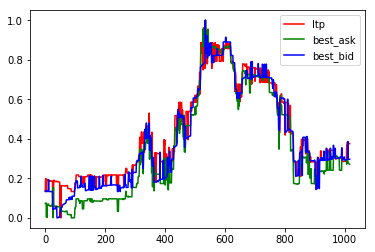

In [75]:
plt.figure()
plt.plot(range(0, len(ltp_data)), ltp_data, color='r', label='ltp')
plt.plot(range(0, len(best_ask_data)), best_ask_data, color='g', label='best_ask')
plt.plot(range(0, len(best_bid_data)), best_bid_data, color='b', label='best_bid')
plt.legend()
plt.show()

In [76]:
ltp_train_data, ltp_train_label = create_reccurent_dataset(ltp_data, step=5)
best_ask_train_data, best_ask_train_label = create_reccurent_dataset(best_ask_data, step=5)
best_bid_train_data, best_bid_train_label = create_reccurent_dataset(best_bid_data, step=5)

In [77]:
print(ltp_train_data.shape)
print(best_ask_train_data.shape)
print(best_bid_train_data.shape)

(1012, 5, 1)
(1012, 5, 1)
(1012, 5, 1)


In [78]:
print(ltp_train_label.shape)
print(best_ask_train_label.shape)
print(best_bid_train_label.shape)

(1012, 1)
(1012, 1)
(1012, 1)


In [79]:
# 推論する際の形状 = (個数, ステップ数, 特徴量)
# 前回の推論時の形状 = (個数, 5, 1)
# 今回の推論時の形状 = (個数, 5, 3)
# 入力も出力もltp, best_ask, best_bidの3つ
train_data = np.c_[ltp_train_data, best_ask_train_data, best_bid_train_data]
train_label = np.c_[ltp_train_label, best_ask_train_label, best_bid_train_label]
print(train_data.shape)
print(train_label.shape)

(1012, 5, 3)
(1012, 3)


In [80]:
# モデル構築
step_count = 5
feature_count = 3
hidden_unit_count = 300

model = Sequential()
model.add(LSTM(hidden_unit_count, batch_input_shape=(None, step_count, feature_count), return_sequences=False))
model.add(Dense(feature_count))
model.add(Activation('linear'))
optimizer = Adam(lr=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer)
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)

In [ ]:
# トレーニング
model.fit(
    train_data, train_label,
    batch_size=2000,
    epochs=200,
    validation_split=0.1,
    callbacks=[early_stopping]
)

In [82]:
# 推論、検証
predictions = model.predict(train_data)

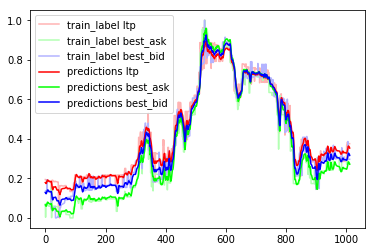

In [83]:
plt.figure()
plt.plot(range(0, len(train_label)), train_label[:,0], color=(1.0, 0.7, 0.7), label='train_label ltp')
plt.plot(range(0, len(train_label)), train_label[:,1], color=(0.7, 1.0, 0.7), label='train_label best_ask')
plt.plot(range(0, len(train_label)), train_label[:,2], color=(0.7, 0.7, 1.0), label='train_label best_bid')
plt.plot(range(0, len(predictions)), predictions[:,0], color=(1.0, 0.0, 0.0), label='predictions ltp')
plt.plot(range(0, len(predictions)), predictions[:,1], color=(0.0, 1.0, 0.0), label='predictions best_ask')
plt.plot(range(0, len(predictions)), predictions[:,2], color=(0.0, 0.0, 1.0), label='predictions best_bid')
plt.legend()
plt.show()

In [84]:
latest_data = np.array([train_data[len(train_data)-1]])
results = []
for _ in range(50):
    # 推論
    batch_predict = model.predict(latest_data)
    # 結果蓄積
    results.append([batch_predict[0][0], batch_predict[0][1], batch_predict[0][2]])
    # 次のデータをセット
    latest_data = np.delete(latest_data, np.array([batch_predict]), axis=1)
    latest_data = np.append(latest_data, np.array([batch_predict]), axis=1)
results = np.array(results)
results.shape

/Users/t01530/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


(50, 3)

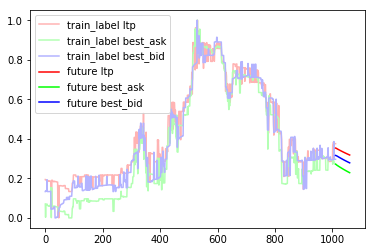

In [85]:
plt.figure()
plt.plot(range(0, len(train_label)), train_label[:,0], color=(1.0, 0.7, 0.7), label='train_label ltp')
plt.plot(range(0, len(train_label)), train_label[:,1], color=(0.7, 1.0, 0.7), label='train_label best_ask')
plt.plot(range(0, len(train_label)), train_label[:,2], color=(0.7, 0.7, 1.0), label='train_label best_bid')
plt.plot(range(len(train_label)-1, len(train_label)-1+len(results)), results[:,0], color=(1.0, 0.0, 0.0), label='future ltp')
plt.plot(range(len(train_label)-1, len(train_label)-1+len(results)), results[:,1], color=(0.0, 1.0, 0.0), label='future best_ask')
plt.plot(range(len(train_label)-1, len(train_label)-1+len(results)), results[:,2], color=(0.0, 0.0, 1.0), label='future best_bid')
plt.legend()
plt.show()

In [86]:
# TODO: リアルタイム予測 and 学習
# 特徴量を増やすと良いかもしれない 最大、最小、ローソク足の最大最小、関連ニュース数(良し悪し別)、曜日

In [87]:
# TODO: RNN  word2vec